- Handling warnings

In [134]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [135]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sns.set_style("whitegrid")
plt.rc('font', size=12)

- Auxiliar functions

In [136]:
def get_metrics(y_true, y_predict, method):
    metrics_estimated = {
        "Method" : method,
        "Accuracy" : accuracy_score(y_true=y_true, y_pred=y_predict),
        "Precision" : precision_score(y_true=y_true, y_pred=y_predict),
        "Recall" : recall_score(y_true=y_true, y_pred=y_predict),
        "F1-score" : f1_score(y_true=y_true, y_pred=y_predict),
        "MCC" : matthews_corrcoef(y_true=y_true, y_pred=y_predict)
    }
    return metrics_estimated

- Preprocessing dataset

In [137]:
df_data = pd.read_csv("../processed_data/1_processed_data_IgA.csv")
df_data.head(5)

,ID,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference,Attachment
0,1,Male,21.765240,28.368055,6.602815,Insecure
1,4,Male,28.473065,50.881961,22.408896,Secure
2,5,Female,161.424693,46.867951,-114.556742,Secure
3,7,Female,24.173487,35.942378,14.343241,Insecure
4,11,Male,78.013279,382.715268,345.590046,Unknown


In [138]:
df_data.columns

Index(['ID', 'Gender', 'IgA_Average_Morning', 'IgA_Average_Afternoon',
       'Average_Difference', 'Attachment'],
      dtype='object')

In [139]:
df_data = df_data[['Gender', 'IgA_Average_Morning', 'IgA_Average_Afternoon',
       'Average_Difference', 'Attachment']]
df_data = df_data.dropna()
df_data["Attachment"] = df_data["Attachment"].replace({"Insecure": 1, "Secure":0, "Unknown":2})
print(df_data.shape)
df_data.head(5)

(35, 5)


,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference,Attachment
0,Male,21.765240,28.368055,6.602815,1
1,Male,28.473065,50.881961,22.408896,0
2,Female,161.424693,46.867951,-114.556742,0
3,Female,24.173487,35.942378,14.343241,1
4,Male,78.013279,382.715268,345.590046,2


In [140]:
df_data["Gender"] = df_data["Gender"].replace({"Female":0, "Male": 1})

In [141]:
df_unknown = df_data[df_data["Attachment"] == 2]
df_unknown = df_unknown.drop(columns=['Attachment'])
df_unknown

,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference
4,1,78.013279,382.715268,345.590046
7,0,19.116347,146.183135,127.066789
10,0,57.810302,24.501335,-33.308967
21,1,18.906715,23.798305,4.891590
28,0,20.707741,18.293268,-2.414473
29,1,101.639013,63.966516,-20.385801
30,1,23.046024,73.899634,50.853611
34,0,120.080399,105.888018,-14.192381


In [142]:
df_data = df_data[df_data["Attachment"] != 2]
response = df_data["Attachment"].values
df_data = df_data.drop(columns=['Attachment'])

- Apply standardization process

In [143]:
scaler_instance = MinMaxScaler()
scaler_instance.fit(df_data.values)
scaled_data = scaler_instance.transform(df_data.values)

df_prepared = pd.DataFrame(data=scaled_data, columns=df_data.columns)
df_prepared["Attachment"] = response
df_prepared.head(5)

,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference,Attachment
0,1.0,0.039765,0.129162,0.666878,1
1,1.0,0.085885,0.411852,0.753876,0
2,0.0,1.000000,0.361451,0.000000,0
3,0.0,0.056323,0.224267,0.709482,1
4,0.0,0.093323,0.338978,0.715977,0


- Using SMOTE for data augmentation

In [144]:
X = df_prepared.drop(columns=['Attachment'])
y = df_prepared['Attachment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print(y_test.shape, y_train.shape)

(9,) (18,)


- 300 per class will be generated

In [145]:
smote = SMOTE(
    random_state=42,
    sampling_strategy={1: 100, 0: 100})

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled["Gender"] = X_train_resampled["Gender"].apply(lambda x: 1 if x > 0.5 else 0)

In [146]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.3, stratify=y_train_resampled, random_state=42
)

In [147]:
X_train.head()

,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference
0,0,1.000000,0.361451,0.000000
148,0,0.045148,0.344042,0.756763
141,0,0.074868,0.090344,0.621761
87,1,0.028696,0.163764,0.690907
188,0,0.085318,0.102486,0.618717


In [148]:
X_val.head()

,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference
107,0,0.096544,0.095912,0.606849
20,0,0.084569,0.195440,0.660064
106,0,0.051960,0.080590,0.635823
136,1,0.066843,0.037003,0.604802
133,0,0.048067,0.065360,0.632264


- Training models

In [149]:
lr_model = LogisticRegression(random_state=42).fit(X=X_train_resampled, y=y_train_resampled)
knn_model = KNeighborsClassifier().fit(X=X_train_resampled, y=y_train_resampled)
dt_model = DecisionTreeClassifier(random_state=42).fit(X=X_train_resampled, y=y_train_resampled)
rf_model = RandomForestClassifier(random_state=42).fit(X=X_train_resampled, y=y_train_resampled)

- Make predictions and get metrics

In [150]:
lr_predictions_val = lr_model.predict(X=X_val)
lr_predictions_test = lr_model.predict(X=X_test)

lr_performances_val = get_metrics(y_true=y_val, y_predict=lr_predictions_val, method="LogisticRegression")
lr_performances_test = get_metrics(y_true=y_test, y_predict=lr_predictions_test, method="LogisticRegression")


In [151]:
knn_predictions_val = knn_model.predict(X=X_val)
knn_predictions_test = knn_model.predict(X=X_test)

knn_performances_val = get_metrics(y_true=y_val, y_predict=knn_predictions_val, method="KNN")
knn_performances_test = get_metrics(y_true=y_test, y_predict=knn_predictions_test, method="KNN")

In [152]:
dt_predictions_val = dt_model.predict(X=X_val)
dt_predictions_test = dt_model.predict(X=X_test)

dt_performances_val = get_metrics(y_true=y_val, y_predict=dt_predictions_val, method="Decision Tree")
dt_performances_test = get_metrics(y_true=y_test, y_predict=dt_predictions_test, method="Decision Tree")

In [153]:
rf_predictions_val = rf_model.predict(X=X_val)
rf_predictions_test = rf_model.predict(X=X_test)

rf_performances_val = get_metrics(y_true=y_val, y_predict=rf_predictions_val, method="Random Forest")
rf_performances_test = get_metrics(y_true=y_test, y_predict=rf_predictions_test, method="Random Forest")

- Making summary of performances

In [154]:
data_performances_val = [
    lr_performances_val,
    knn_performances_val,
    dt_performances_val,
    rf_performances_val
]

df_perfomances_val = pd.DataFrame(data_performances_val)
df_perfomances_val

,Method,Accuracy,Precision,Recall,F1-score,MCC
0,LogisticRegression,0.666667,0.631579,0.800000,0.705882,0.345857
1,KNN,0.966667,0.966667,0.966667,0.966667,0.933333
2,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000


In [155]:
data_performances_test = [
    lr_performances_test,
    knn_performances_test,
    dt_performances_test,
    rf_performances_test
]

df_perfomances_test = pd.DataFrame(data_performances_test)
df_perfomances_test

,Method,Accuracy,Precision,Recall,F1-score,MCC
0,LogisticRegression,0.666667,0.500000,0.666667,0.571429,0.316228
1,KNN,0.333333,0.000000,0.000000,0.000000,-0.500000
2,Decision Tree,0.777778,0.666667,0.666667,0.666667,0.500000
3,Random Forest,0.777778,0.666667,0.666667,0.666667,0.500000


- Making analyzis based on classification model. In this case, we only will select the Decision tree and the Random Forest models

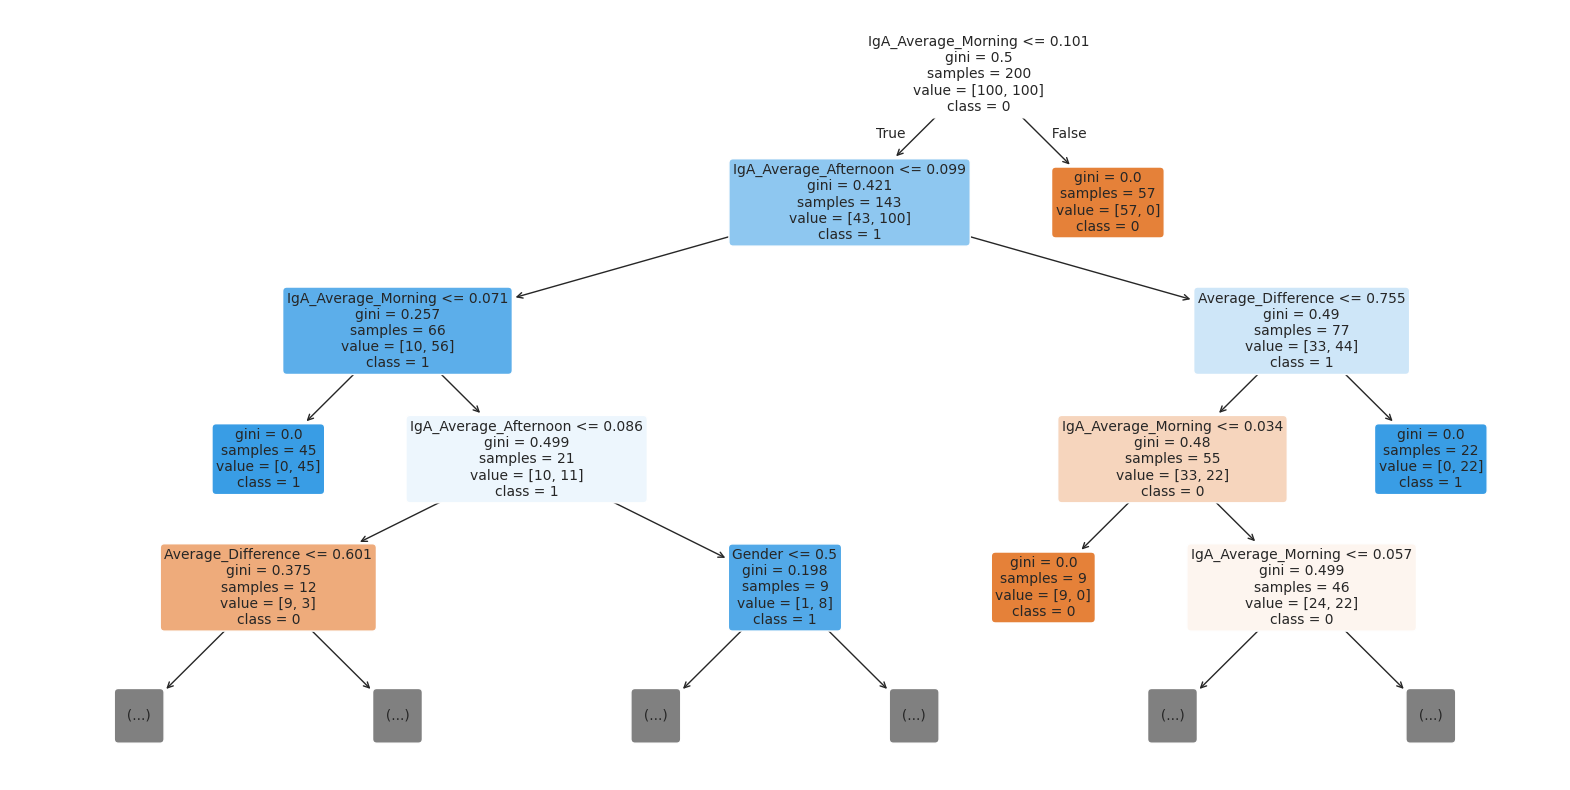

In [156]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=[str(c) for c in dt_model.classes_],
    filled=True,
    rounded=True,
    max_depth=4,
    fontsize=10
)

plt.show()

- Feature relevance Random Forest

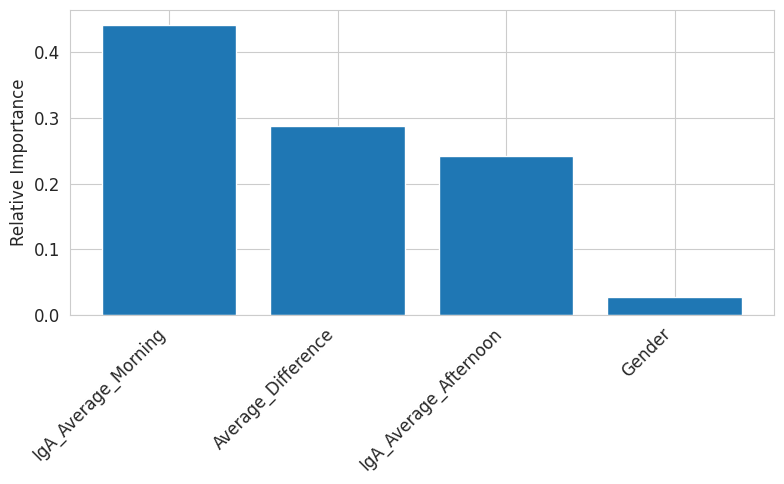

In [157]:
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha='right')
plt.ylabel("Relative Importance")
plt.tight_layout()
plt.show()

- Using the model to classify the unknown examples

In [158]:
rf_model.predict(scaler_instance.transform(df_unknown.values))

array([0, 1, 0, 1, 1, 0, 1, 0])

In [159]:
rf_model.predict_proba(scaler_instance.transform(df_unknown.values))

array([[0.65, 0.35],
       [0.12, 0.88],
       [1.  , 0.  ],
       [0.14, 0.86],
       [0.32, 0.68],
       [0.9 , 0.1 ],
       [0.  , 1.  ],
       [0.92, 0.08]])

In [160]:
dt_model.predict(scaler_instance.transform(df_unknown.values))

array([0, 1, 0, 1, 1, 0, 1, 0])

In [161]:
df_unknown['Attachment'] = rf_model.predict(scaler_instance.transform(df_unknown.values))

- Making visualization of the predictions

In [162]:
df_unknown['Attachment'].value_counts()

Attachment
0    4
1    4
Name: count, dtype: int64

In [163]:
df_unknown.head()

,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference,Attachment
4,1,78.013279,382.715268,345.590046,0
7,0,19.116347,146.183135,127.066789,1
10,0,57.810302,24.501335,-33.308967,0
21,1,18.906715,23.798305,4.891590,1
28,0,20.707741,18.293268,-2.414473,1


In [164]:
df_data['Attachment'] = response
df_data['Attachment'].value_counts()

Attachment
0    18
1     9
Name: count, dtype: int64

In [165]:
df_data["Attachment"] = df_data["Attachment"].replace({1: "Insecure", 0: "Secure"})
df_unknown['Attachment'] = df_unknown['Attachment'].replace({1: "(P) Insecure", 0: "(P) Secure"})

In [166]:
df_concat = pd.concat([df_data, df_unknown], axis=0)

In [167]:
df_concat['Attachment'].value_counts()

Attachment
Secure          18
Insecure         9
(P) Secure       4
(P) Insecure     4
Name: count, dtype: int64

In [168]:
from sklearn.manifold import TSNE

In [170]:
df_concat.columns

Index(['Gender', 'IgA_Average_Morning', 'IgA_Average_Afternoon',
       'Average_Difference', 'Attachment'],
      dtype='object')

In [171]:
df_for_reductions = df_concat[['IgA_Average_Morning', 'IgA_Average_Afternoon',
       'Average_Difference']]
df_for_reductions.head()

,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference
0,21.765240,28.368055,6.602815
1,28.473065,50.881961,22.408896
2,161.424693,46.867951,-114.556742
3,24.173487,35.942378,14.343241
5,29.554870,45.078186,15.523316


In [174]:
tsne_instance = TSNE(n_components=2, perplexity=3)
header = ["t-SNE1", "t-SNE2"]
tsne_data_transformed = pd.DataFrame(
    data=tsne_instance.fit_transform(df_for_reductions.values),
    columns=header,
    index=df_for_reductions.index)
tsne_data_transformed.head(5)

,t-SNE1,t-SNE2
0,-40.038315,-103.254570
1,-18.327919,-40.559719
2,-25.907005,123.936455
3,-19.642025,-75.309265
5,-9.900530,-51.558651


In [175]:
tsne_data_transformed = pd.concat([tsne_data_transformed, df_concat], axis=1)
tsne_data_transformed.head(5)

,t-SNE1,t-SNE2,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference,Attachment
0,-40.038315,-103.254570,1,21.765240,28.368055,6.602815,Insecure
1,-18.327919,-40.559719,1,28.473065,50.881961,22.408896,Secure
2,-25.907005,123.936455,0,161.424693,46.867951,-114.556742,Secure
3,-19.642025,-75.309265,0,24.173487,35.942378,14.343241,Insecure
5,-9.900530,-51.558651,0,29.554870,45.078186,15.523316,Secure


In [179]:
tsne_data_transformed['Gender'] = tsne_data_transformed['Gender'].replace({0:"Female", 1:"Male"})

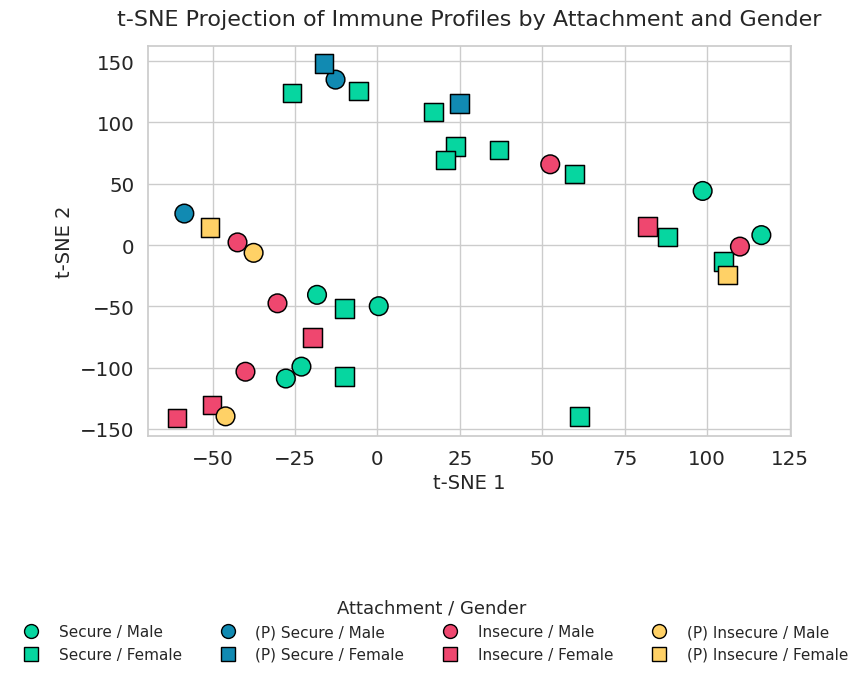

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Estilo general
sns.set(style="whitegrid", font_scale=1.3)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(8, 6))

# Paletas y marcadores
palette = {
    "Insecure": "#EF476F",
    "(P) Insecure": "#FFD166",
    "Secure": "#06D6A0",
    "(P) Secure": "#118AB2"
}
markers = {"Male": "o", "Female": "s"}

# Scatterplot principal
sns.scatterplot(
    ax=ax,
    data=tsne_data_transformed,
    x="t-SNE1",
    y="t-SNE2",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=180,
    edgecolor="black"
)

# Títulos y etiquetas
ax.set_title("t-SNE Projection of Immune Profiles by Attachment and Gender", fontsize=16, pad=15)
ax.set_xlabel("t-SNE 1", fontsize=14)
ax.set_ylabel("t-SNE 2", fontsize=14)

# Quitar la leyenda automática
ax.get_legend().remove()

# Leyenda personalizada (Attachment / Gender)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Secure / Male',
           markerfacecolor=palette["Secure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='Secure / Female',
           markerfacecolor=palette["Secure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='(P) Secure / Male',
           markerfacecolor=palette["(P) Secure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='(P) Secure / Female',
           markerfacecolor=palette["(P) Secure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Insecure / Male',
           markerfacecolor=palette["Insecure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='Insecure / Female',
           markerfacecolor=palette["Insecure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='(P) Insecure / Male',
           markerfacecolor=palette["(P) Insecure"], markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='(P) Insecure / Female',
           markerfacecolor=palette["(P) Insecure"], markeredgecolor='black', markersize=10),
]

# Añadir leyenda final
fig.legend(
    handles=legend_elements,
    title="Attachment / Gender",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False,
    fontsize=11,
    title_fontsize=13
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

